In [1]:
import numpy as np
import imageio as imio
import matplotlib.pyplot as plt
from sklearn import datasets
import tensorflow as tf
import pandas as pd
import datetime, os

Si tienes algún error al ejecutar la celda anterior verifica que tu ambiente de anaconda tenga las librerías necesarias.

In [23]:
if tf.__version__.startswith("2."):
  import tensorflow.compat.v1 as tf
  tf.compat.v1.disable_v2_behavior()
  tf.compat.v1.disable_eager_execution()
  print("Enabled compatitility to tf1.x")

Enabled compatitility to tf1.x


In [19]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [20]:
logs_base_dir = "./logs"
os.makedirs(logs_base_dir, exist_ok=True)

# Clasificación con K-nearest neighbors
En este notebook vamos a implementar K-nearest neighbor, nuestro algoritmo va a **clasificar** a que raza pertenece la imagen de un perro, para entrenar nuestro algoritmo vamos a utilizar un set de datos contiene imagenes de 120 razas de perros, en total son 10,222 imagenes.

Data: [Dog Breed Identification](https://www.kaggle.com/c/dog-breed-identification/data)

#### Pre-procesamiento

El pre-procesamiento ya fue realizado y el dataset preparado y esta listo para usarse, para esto se aplico un proceso conocido como "transfer learning" usando la red neuronal "Inception" de Google(tema a cubrirse en proximas clases)  , para esta tarea ignoremos este detalle  y pensemos que se nos da un dataset con features donde cada columna representa una característica de entrada importante,pero no nos interesa conocer los detalles. 

Estas features/características fueron almacenadas en un matriz de numpy.

En esta parte del notebook solo hay que ejecutar las celdas para cargar los datos, estos datos van a servir de entrada para nuestra implementación de K-nearest neighbors con tensorflow.

### Referencias opcionales para transfer learning y "Google inception"
##### Inception
https://www.tensorflow.org/tutorials/image_recognition

https://research.googleblog.com/2016/03/train-your-own-image-classifier-with.html

##### Transfer Learning
https://www.datacamp.com/community/tutorials/transfer-learning

In [5]:
images_inception_features = './pre-processing/training_inception_features_array.npy'
training_image_labels_array = './pre-processing/training_image_labels_array.npy'
training_image_names_array = './pre-processing/training_image_names_array.npy'

In [17]:
TRAIN_DICTIONARY_KEYS = ["images", "label","features"]

training_set_dict = dict()
    
training_set_dict['images_name'] = np.load(training_image_names_array,allow_pickle=True)
training_set_dict['label'] = np.load(training_image_labels_array,allow_pickle=True)
training_set_dict['features'] = np.load(images_inception_features,allow_pickle=True)



#  K-Nearest Neighbors

La data la vamos a manejar en los siguientes 3 arreglos: 

- features    : features de la imagen dadas por google Inception
- labels      : label de la imagen, identifica que raza es
- images_name : nombre de la imgen original, si descargan el dataset con link en la descripcion pueden buscar la imagen original por este nombre.

In [7]:
## Cargamos las features y las labes de cada feature
features = training_set_dict['features']
labels = training_set_dict['label']
images_name = training_set_dict['images_name']
len(images_name)

10222

Las labels pertenecientes a las features tienen el mismo indice, Ejemplo:

### Implementa tu codigo de  K-Neighbors aqui:

El siguiente es un ejemplo de como puedes  definir tu función para predecir la raza sobre un punto x_predict ,a través de uscar los "k" vecinos mas cercanos en X_train y devolver como predicción el "y" que mas se repite(la moda) correspondiente a esos "k" valores de X_train , este "y" estará dado por Y_train.

Un ejemplo  de KNN en tensorflow: http://marubon-ds.blogspot.com/2017/09/knn-k-nearest-neighbors-by-tensorflow.html (este tiene diferencias, usar como guía no copiar literal, por ejemplo este usa una métrica de distancia diferente a la que debemos usar: distancia euclidiana )


#### Instrucciones:
1. Implementar KNN
2. Agregar el grafo de tensorboard
3. Ejecutar el modelo con las 2 imagenes de prueba.

In [24]:
def predecir_raza_KNN(X_predict,X_train,Y_train,k):
    y = Y_train
    distance = tf.norm(X_train - X_predict, ord='euclidean', axis=1)
    top_k_values, top_k_indices = tf.nn.top_k(tf.negative(distance), k=k)
    top_k_label = tf.gather(Y_train, top_k_indices)
    y, idx, cnts = tf.unique_with_counts(top_k_label)
    index = tf.argmax(cnts)
    return (y[0])

## Probamos el algoritmo con nuevas imagenes 

Como buena practica luego de entrenar nuestro algoritmo, lo probamos con imagenes que no ha visto antes 

In [53]:
test_features = np.load('./data/test/test_inception_features_array.npy')

### Prueba 1

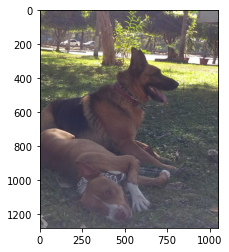

In [33]:
## Ejecuta tu modelo con la entrada de `predict_image`
# Deberiamos obtener: german_shepherd
img_test = imio.imread('./data/test/test1.jpg')
plt.imshow(img_test)
predict_image = test_features[0]
#pd.DataFrame(predict_image)

In [44]:
row_number,feature_number = features.shape

x_data_train = tf.placeholder(tf.float32,[row_number, feature_number], "Feature")
y_data_train = tf.placeholder(tf.string,[len(labels)], "Label")
x_data_test = tf.placeholder(tf.float32,[len(predict_image)], "Test")

Predecir_Raza = predecir_raza_KNN(x_data_test,x_data_train,y_data_train,100)

with tf.train.MonitoredSession() as session:
    tf.reset_default_graph()   
    log_dir = "logs/KNN/"+"Test"+"_"+ datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    Grafo = tf.summary.FileWriter(log_dir, session.graph)

    feed_dict={x_data_test: predict_image,x_data_train: features, y_data_train: labels}
    Y_Prediction = session.run([Predecir_Raza],feed_dict=feed_dict) 
    print("Raza",Y_Prediction)
    #print(c)
    
    Grafo.close()

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Raza [b'german_shepherd']


### Prueba 2

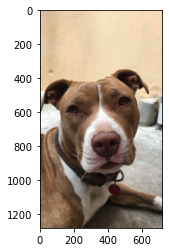

In [51]:
img_test = imio.imread('./data/test/test2.jpg')
plt.imshow(img_test)
predict_image2 = test_features[1]

In [52]:
## Ejecuta tu modelo con la entrada de `predict_image`
# Deberiamos obtener: american_staffordshire_terrier #
row_number,feature_number = features.shape

x_data_train = tf.placeholder(tf.float32,[row_number, feature_number], "Feature")
y_data_train = tf.placeholder(tf.string,[len(labels)], "Label")
x_data_test = tf.placeholder(tf.float32,[len(predict_image)], "Test")

Predecir_Raza = predecir_raza_KNN(x_data_test,x_data_train,y_data_train,100)

with tf.train.MonitoredSession() as session:
    tf.reset_default_graph()   
    log_dir = "logs/KNN/"+"Test"+"_"+ datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    Grafo = tf.summary.FileWriter(log_dir, session.graph)

    feed_dict={x_data_test: predict_image2,x_data_train: features, y_data_train: labels}
    Y_Prediction = session.run([Predecir_Raza],feed_dict=feed_dict) 
    print("Raza: ",Y_Prediction)
    
    Grafo.close()


INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Raza:  [b'american_staffordshire_terrier']


### Prueba 3

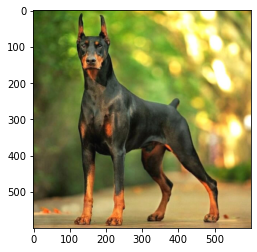

In [47]:
## Ejecuta tu modelo con la entrada de `predict_image`
# Deberiamos obtener: german_shepherd
img_test = imio.imread('./data/test/test3.jpg')
plt.imshow(img_test)
predict_image3 = test_features[1]
#pd.DataFrame(predict_image)

In [48]:
## Ejecuta tu modelo con la entrada de `predict_image`
# Deberiamos obtener: american_staffordshire_terrier #
row_number,feature_number = features.shape

x_data_train = tf.placeholder(tf.float32,[row_number, feature_number], "Feature")
y_data_train = tf.placeholder(tf.string,[len(labels)], "Label")
x_data_test = tf.placeholder(tf.float32,[len(predict_image)], "Test")

Predecir_Raza = predecir_raza_KNN(x_data_test,x_data_train,y_data_train,100)

with tf.train.MonitoredSession() as session:
    tf.reset_default_graph()   
    log_dir = "logs/KNN/"+"Test"+"_"+ datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    Grafo = tf.summary.FileWriter(log_dir, session.graph)

    feed_dict={x_data_test: predict_image3,x_data_train: features, y_data_train: labels}
    Y_Prediction = session.run([Predecir_Raza],feed_dict=feed_dict) 
    print("Raza: ",Y_Prediction)
    
    Grafo.close()

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Raza:  [b'american_staffordshire_terrier']


In [40]:
%tensorboard --logdir logs/KNN

Reusing TensorBoard on port 6006 (pid 4064), started 0:17:23 ago. (Use '!kill 4064' to kill it.)

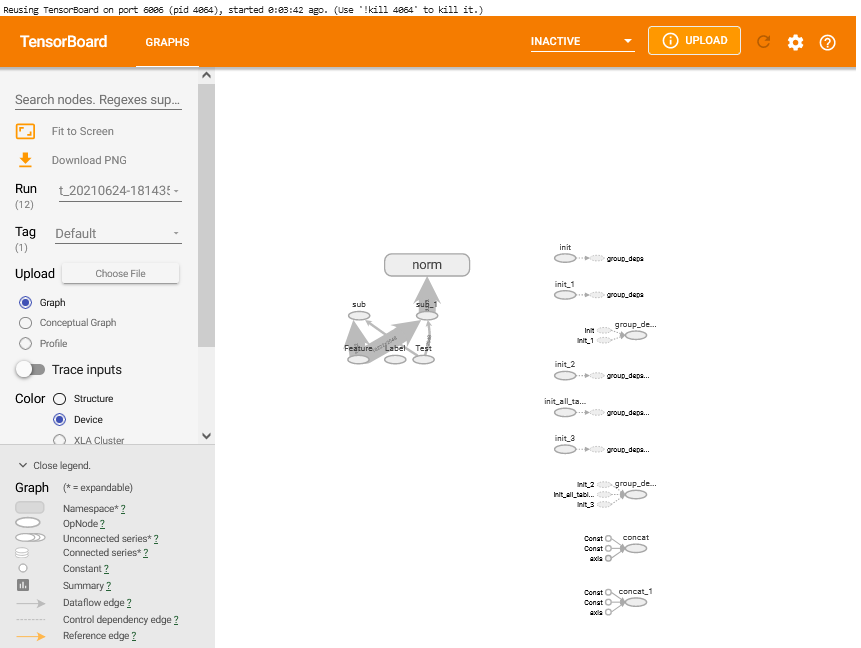